In [ ]:
'''
Copyright (C) 2024 Fabio Bonassi, Carl Andersson, and co-authors

This file is part of learning-rrn-observers-cdc24.

learning-rrn-observers-cdc24 is free software: you can redistribute it 
and/or modify it under the terms of the GNU General Public License as 
published by the Free Software Foundation, either version 3 of the License, 
or (at your option) any later version.

learning-rrn-observers-cdc24  is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU Lesser General Public License for more details.

You should have received a copy of the GNU General Public License
along with learning-rrn-observers-cdc24.  
If not, see <http://www.gnu.org/licenses/>.
'''

In [17]:
import json
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import torch
from ttictoc import tictoc
from scipy.io.matlab import loadmat
from online_forecasting_helper import online_forecasting

params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "axes.labelsize": "x-large",
          "axes.titlesize": "x-large",
          "xtick.labelsize": "large",
          "ytick.labelsize": "large",
          "text.usetex" : True,
          "font.family" : "serif",
          "font.serif" : ["Computer Modern Serif"]}

plt.rcParams.update(params)

In [ ]:
flag_move_folders = True
common_folder = 'training_outputs'
folders_to_move = 'training_output_2311*'

figure_folder = 'figures_new'

In [19]:
# List all the folders matching the folders_to_move pattern
# Move all the subfolders of such folder to common_folder
if flag_move_folders:
    if not os.path.exists(common_folder):
        os.makedirs(common_folder)

    folders = [f for f in os.listdir('.') if re.match(folders_to_move, f)]
    
    for folder in folders:
        for subfolder in os.listdir(folder):
            if os.path.exists(os.path.join(common_folder, subfolder)):
                i = 1
                new_subfolder = subfolder + '_' + str(i)

                while os.path.exists(os.path.join(common_folder, new_subfolder)):
                    i += 1
                    new_subfolder = subfolder + '_' + str(i)
            else:
                 new_subfolder = subfolder

            os.rename(os.path.join(folder, subfolder), os.path.join(common_folder, new_subfolder))
        os.rmdir(folder)

if not os.path.exists(figure_folder):
    os.makedirs(figure_folder)

Load the data
---

In [20]:
# Load the dictionary from summary.json in any subfolder of common_folder
# and enter its fields into a pandas dataframe
summary = {}

for folder in os.listdir(common_folder):
    if os.path.isdir(os.path.join(common_folder, folder)):
        with open(os.path.join(common_folder, folder, 'summary.json')) as f:
            summ = json.load(f)

        is_parscan = summ['observer_params'].get('use_parallel_scan', False)

        summary[folder] = {
            'epochs': summ['required_epochs'],
            'batch_size': summ['training_params']['batch_size'],
            'Ts': summ['tbptt_params']['Ts_train'],
            'Ns': summ['tbptt_params']['Ns_train'],
            'FIT': summ['final_test_metrics']['fit'],
            'context_window': summ['tbptt_params']['context_window'],
            'n_params': summ.get('observer_num_trainable_params', 'N/A'),
            'observer': summ['observer_params'].get('model', 'None') + ('_parscan' if is_parscan else ''),
            'time_per_epoch': summ['seconds_per_epoch']
        }

df = pd.DataFrame.from_dict(summary, orient='index')
df['total_batches'] = (df['Ns'] / df['batch_size']).apply(np.ceil) * df['epochs']

In [21]:
# Remove extremely bad runs
df = df[df['FIT'] > 90.0]
df_full = df
df = df[df['context_window'] > 0]
df_no_obsv = df_full[df_full['context_window'] == 0]

In [22]:
# df = df.sort_values(by=['FIT'], ascending=False)
# df_ = df[df['observer'] == 'S5Model_parscan']
# df_ = df_[df_['n_params'] < 200]
# # Delete the rows of df_ from df
# df = df.drop(df_.index)

Box plots
---

In [23]:
obsv_scheme = OrderedDict()
obsv_scheme['SingleLayerLSTM'] = {'color': 'tab:red', 'shortname': 'LSTM', 'label': 'LSTM observer'}
obsv_scheme['SingleLayerGRU'] = {'color': 'tab:orange', 'shortname': 'GRU', 'label': 'GRU observer'}
obsv_scheme['FFNNObserver'] = {'color': 'tab:green', 'shortname': 'MLP', 'label': 'MLP observer'}
obsv_scheme['S5Model_parscan'] = {'color': 'tab:blue', 'shortname': 'S5', 'label': 'S5 observer'}
obsv_scheme['None'] = {'color': 'black', 'shortname': 'None', 'label': 'No observer'}

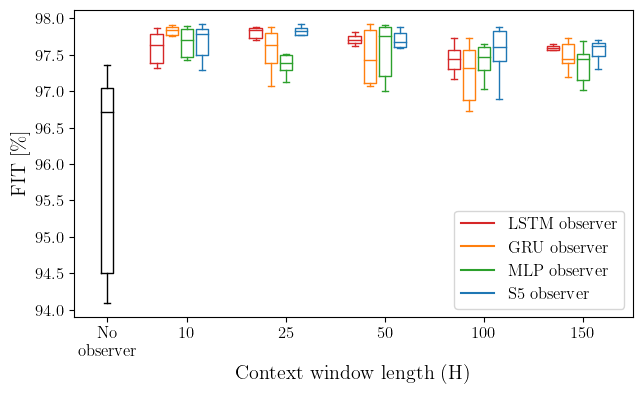

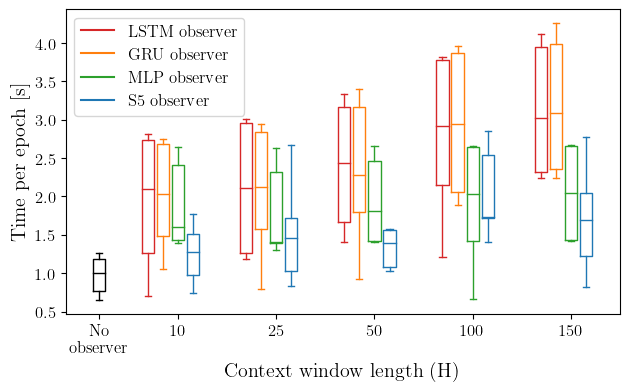

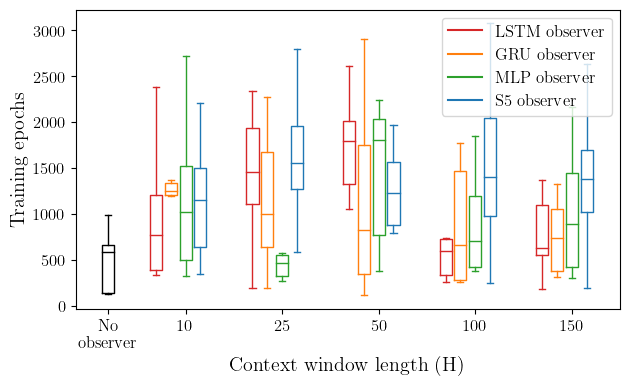

In [24]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)
       

def plot_boxplot(df, axis="FIT", label="FIT", osbv_scheme=obsv_scheme, df_no_obsv = None, legend: bool = False):
    fig = plt.figure()
    ax = fig.add_subplot()
    
    obsvs = [obsv_class for obsv_class in osbv_scheme.keys() if obsv_class in df['observer'].unique()]
    total_boxes = len(obsvs)
    box_width = 1.75/(total_boxes) # + 1?
    box_spacing = 0.1
    group_width = 3.5 

    n_cw = len(df['context_window'].unique())
    cw_ticks = np.arange(n_cw) * group_width + (box_width + box_spacing) * total_boxes / 2.0

    for i, obsv in enumerate(obsvs):
        df_ = df[df['observer'] == obsv]
        data = df_[[axis, "context_window"]]
        data = data.groupby("context_window")[axis].apply(list)
        data.sort_values()
        bp = ax.boxplot(data, positions=np.arange(len(data)) * group_width + i*(box_width + box_spacing), sym='', widths=box_width)
        set_box_color(bp, osbv_scheme[obsv]['color'])

    if df_no_obsv is not None:
        cw_pos = -np.ones(1) * (group_width) / 2.0
        cw_ticks = np.insert(cw_ticks, 0, cw_pos)
        data = df_no_obsv[axis].to_frame()
        bp = ax.boxplot(data, positions=cw_pos, sym='', widths=box_width)
        set_box_color(bp, osbv_scheme['None']['color'])
        
    ticks = df['context_window'].unique()
    ticks.sort()
    ticks_label = [str(x) for x in ticks]
    if df_no_obsv is not None:
        ticks_label = ['No\nobserver'] + ticks_label
        low_margin = group_width / 3.0
    else:
        low_margin = group_width / 2.0 + box_width
    
    ax.set_xticks(cw_ticks, ticks_label)
    ax.set_xlim(cw_ticks[0] - low_margin, cw_ticks[-1] + group_width / 2.0)
    ax.set_xlabel("Context window length (H)")

    ax.set_ylabel(label)
    ax.set_box_aspect(0.55)
    fig.tight_layout()

    if legend:
        for obsv in obsvs:
            ax.plot([], c=osbv_scheme[obsv]['color'], label=osbv_scheme[obsv]['label'])
        # Legend with font size
        ax.legend(fontsize='large')

    return fig
    
fig_fit = plot_boxplot(df, "FIT", "FIT [\%]", df_no_obsv=df_no_obsv, legend=True)
fig_time = plot_boxplot(df, "time_per_epoch", "Time per epoch [s]", df_no_obsv=df_no_obsv, legend=True) 
fig_epochs = plot_boxplot(df, "epochs", "Training epochs", df_no_obsv=df_no_obsv, legend=True)

In [25]:
# Save the figures
fig_fit.savefig(os.path.join(figure_folder, 'fit_boxes.pdf'), format='pdf', bbox_inches='tight')
fig_time.savefig(os.path.join(figure_folder, 'time_boxes.pdf'), format='pdf', bbox_inches='tight')
fig_epochs.savefig(os.path.join(figure_folder, 'epochs_boxes.pdf'), format='pdf', bbox_inches='tight')

Validation of the trained networks
---

We want to estimate a confidence interval for the online prediction error.

In [26]:
# Compute the average online prediction for the top k models of each architecture for the given context_window
top_k_models = 1
prediction_horizon = 40
confidence = 95.0

In [27]:
data = loadmat('Datasets/PH/Dataset_6000.mat')
U_test = torch.tensor(data['U_test'], dtype=torch.float32)
Y_test = torch.tensor(data['Y_test'], dtype=torch.float32)
error_dict = {}

Predicting without observer - Elapsed time: 6.01980695797829 s
Predicting with observer SingleLayerLSTM for cw=25 - Elapsed time: 9.171873291023076 s
Predicting with observer SingleLayerGRU for cw=25 - Elapsed time: 8.984683124988806 s
Predicting with observer FFNNObserver for cw=25 - Elapsed time: 5.684203542012256 s
Predicting with observer S5Model_parscan for cw=25 - Elapsed time: 6.9041296250070445 s
Predicting without observer - Elapsed time: 5.905435541004408 s
Predicting with observer SingleLayerLSTM for cw=100 - Elapsed time: 17.60762737499317 s
Predicting with observer SingleLayerGRU for cw=100 - Elapsed time: 18.303251500008628 s
Predicting with observer FFNNObserver for cw=100 - Elapsed time: 5.775826541997958 s
Predicting with observer S5Model_parscan for cw=100 - Elapsed time: 6.738188791961875 s


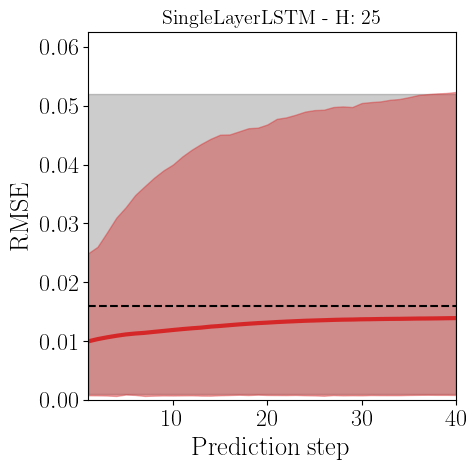

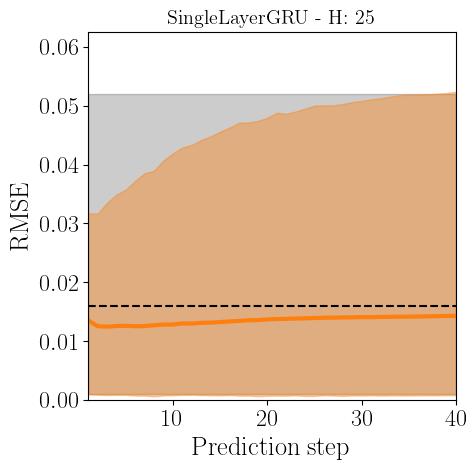

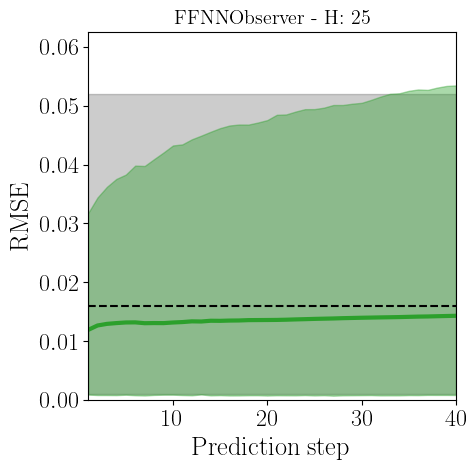

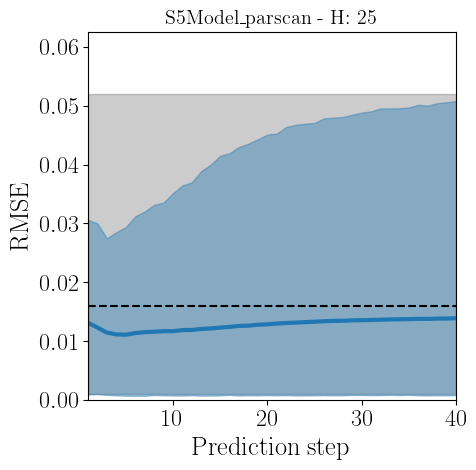

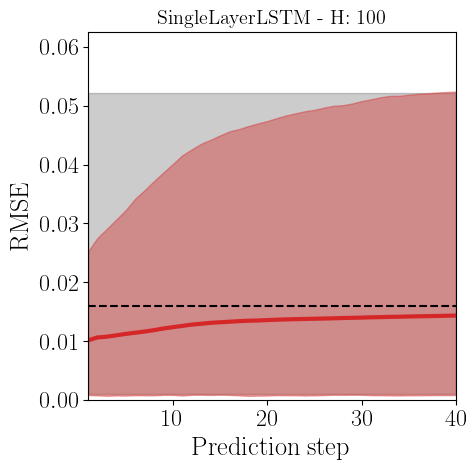

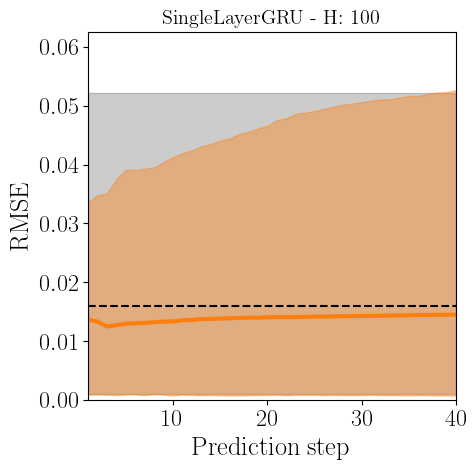

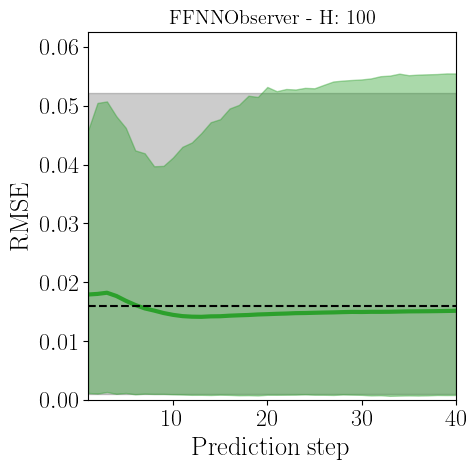

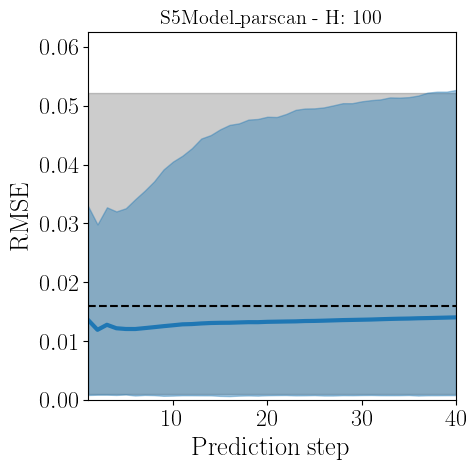

In [28]:
def test_model_online_forecasting(model_name: str, context_window: int, prediction_horizon: int):
    model_path = os.path.join(common_folder, model_name, 'trained_network.pt')
    full = torch.load(model_path)

    err = online_forecasting(full, U_test, Y_test, context_window, prediction_horizon)
    err = err.detach().numpy()
    return err


def plot_online_forecasting(df, 
                            context_window, 
                            top_k_models: int = 1, 
                            prediction_horizon: int = 40, 
                            confidence: float = 95.0, 
                            obsv_scheme=obsv_scheme, 
                            df_no_obsv = None, 
                            compare_to_no_obsv: bool = True,
                            center: str = 'avg'):
    error_dict = OrderedDict()
    observer_classes = [x for x in obsv_scheme.keys() if x in df['observer'].unique()]

    # First, test the model without observer
    if df_no_obsv is not None and len(df_no_obsv) > 0:
        best_no_obsv = df_no_obsv.sort_values(by=['FIT'], ascending=False)[:top_k_models]
        errors = []

        for m in best_no_obsv.index:
            print(f'Predicting without observer - ', end='')
            tictoc.tic()
            err = test_model_online_forecasting(m, 0, prediction_horizon)
            print(f'Elapsed time: {tictoc.toc()} s')
            errors.append(err)
        
        errors = np.concatenate(errors, axis=0)
        error_dict['None'] = { 'avg': np.mean(errors, axis=(0, 1)), 
                               'median': np.median(errors, axis=(0, 1)), 
                               'low_percentile': np.percentile(errors, 100.0 - confidence, axis=(0, 1)),
                               'high_percentile': np.percentile(errors, confidence, axis=(0, 1)) }  


    # Then, test all the observer models
    for obsv_class in observer_classes:
        best_models = df[(df['observer'] == obsv_class) & (df['context_window'] == context_window)].sort_values(by=['FIT'], ascending=False)[:top_k_models]
        errors = []

        for m in best_models.index:
            tictoc.tic()
            print(f'Predicting with observer {obsv_class} for cw={context_window} - ', end='')
            err = test_model_online_forecasting(m, context_window, prediction_horizon)
            print(f'Elapsed time: {tictoc.toc()} s')
            errors.append(err)

        errors = np.concatenate(errors, axis=0)
        error_dict[obsv_class] = { 'avg': np.mean(errors, axis=0), 
                                   'median': np.median(errors, axis=0), 
                                   'low_percentile': np.percentile(errors, 100.0 - confidence, axis=0),
                                   'high_percentile': np.percentile(errors, confidence, axis=0) }  
    
    # Ceil to multiple of 0.025
    max_error = np.max([np.max(error_dict[obsv]['high_percentile']) for obsv in error_dict.keys()])
    max_error = np.ceil(max_error / 0.0125) * 0.0125

    figs = {}
    axes = {}

    for obsv in error_dict.keys():
        if obsv == 'None':
            continue
        fig = plt.figure()
        ax = fig.add_subplot()

        if compare_to_no_obsv and obsv != 'None' and 'None' in error_dict.keys():
            ax.fill_between(np.arange(prediction_horizon) + 1, 
                           error_dict['None']['low_percentile'].flatten() * np.ones(prediction_horizon),
                           error_dict['None']['high_percentile'].flatten() * np.ones(prediction_horizon), 
                           color=obsv_scheme['None']['color'], 
                           alpha=0.2)

        # ax.plot(np.arange(prediction_horizon) + 1, error_dict[obsv]['avg'].flatten(), color=obsv_scheme[obsv]['color'], label=obsv_scheme[obsv]['shortname'])
        ax.plot(np.arange(prediction_horizon) + 1, error_dict[obsv][center].flatten(), color=obsv_scheme[obsv]['color'], label=obsv_scheme[obsv]['shortname'], linewidth=3.0)

        ax.fill_between(np.arange(prediction_horizon) + 1, 
                       error_dict[obsv]['low_percentile'].flatten(), 
                       error_dict[obsv]['high_percentile'].flatten(), color=obsv_scheme[obsv]['color'], alpha=0.4)

        if compare_to_no_obsv and obsv != 'None' and 'None' in error_dict.keys():
            # ax.plot(np.arange(prediction_horizon) + 1, error_dict['None']['avg'].flatten(), color=obsv_scheme['None']['color'], label=obsv_scheme[obsv]['shortname'], linestyle='--')
            ax.plot(np.arange(prediction_horizon) + 1, 
                    error_dict['None'][center].flatten() * np.ones(prediction_horizon), 
                    color=obsv_scheme['None']['color'], 
                    label=obsv_scheme[obsv]['shortname'], 
                    linestyle='--')

        ax.set_box_aspect(1)
        ax.set_xlim(1, prediction_horizon)
        ax.set_ylim(0, max_error)
        ax.set_xlabel('Prediction step', fontsize=19)
        ax.set_ylabel('RMSE', fontsize=19)
        ax.set_title(f'{obsv} - H: {"None" if obsv == "None" else context_window}')
        ax.tick_params(axis='both', which='major', labelsize='xx-large')

        fig.tight_layout()

        axes[obsv_scheme[obsv]['shortname']] = ax
        figs[obsv_scheme[obsv]['shortname']] = fig

    return figs, axes, error_dict

figures_online_25, _, _ = plot_online_forecasting(df, context_window=25, prediction_horizon=40, confidence = 95.0, df_no_obsv=df_no_obsv, center='avg')
figures_online_100, _, _ = plot_online_forecasting(df, context_window=100, prediction_horizon=40, confidence = 95.0, df_no_obsv=df_no_obsv, center='avg')

In [29]:
for obsv, fig in figures_online_25.items():
    # Remove title from figure's exes
    for ax in fig.axes:
        ax.set_title('')
    fig.savefig(os.path.join(figure_folder, f'online_prediction_H25_{obsv}.pdf'), format='pdf', bbox_inches='tight')

for obsv, fig in figures_online_100.items():
    # Remove title from figure's exes
    for ax in fig.axes:
        ax.set_title('')
    fig.savefig(os.path.join(figure_folder, f'online_prediction_H100_{obsv}.pdf'), format='pdf', bbox_inches='tight')

FIT evolution during training
---

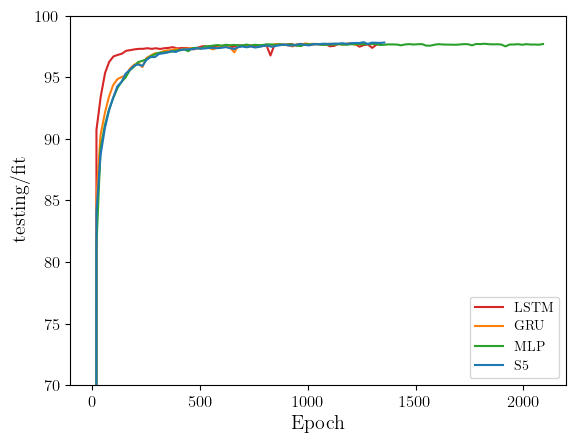

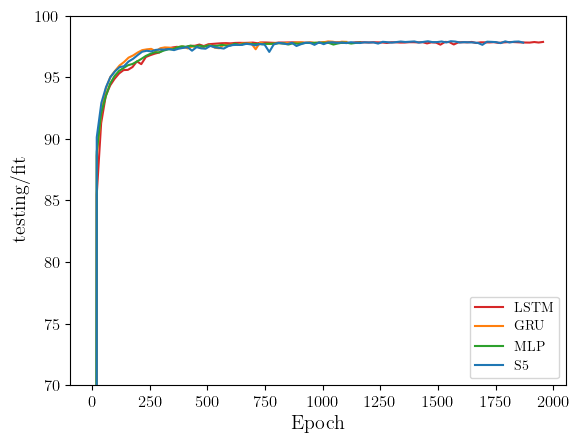

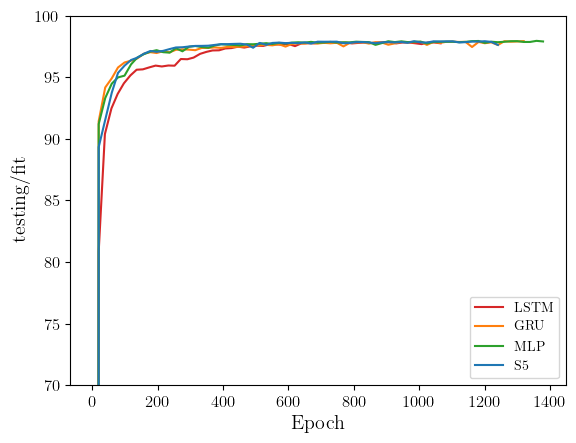

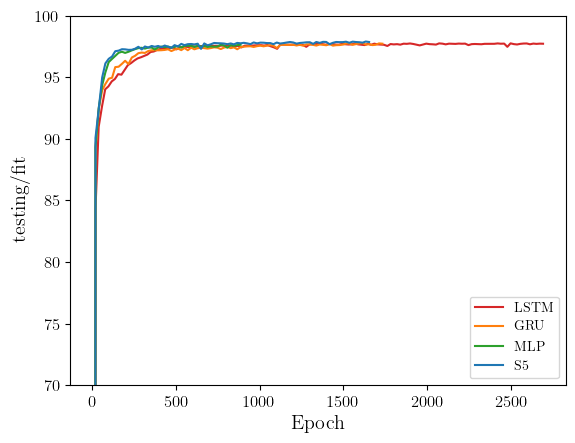

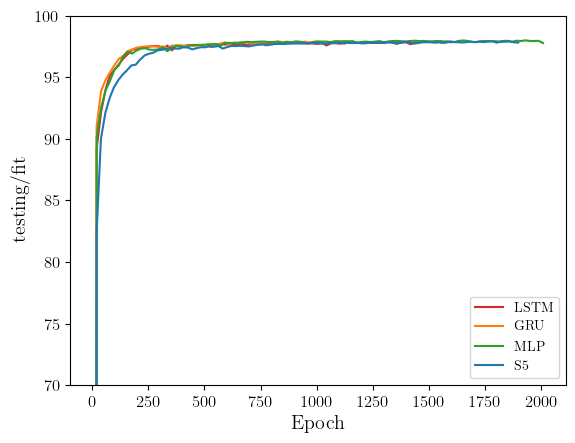

In [30]:
from tbparse import SummaryReader


def plot_from_tensorboard(best_model, series, ax, obsv_scheme=obsv_scheme):
    tensorboard_dir = os.path.join(common_folder, best_model.name, 'lightning_logs/version_0/')
    # find the file matching "events.out.tfevents.*.20" in tensorboard_dir/
    tensorboard_files = [f for f in os.listdir(tensorboard_dir) if re.match('events.out.tfevents.*', f)]

    for file in tensorboard_files:
        tbf = os.path.join(tensorboard_dir, file)
        reader = SummaryReader(tbf)
        logs = reader.scalars

        if 'validation_metric' in logs['tag'].unique():
            sr = logs[logs['tag'] == series]
            epochs = logs[logs['tag'] == 'epoch']
            epochs = epochs.loc[sr['step']]

            # Keep only those before the early stopping
            # early_stop_epoch = int(best_model['epochs'])
            # epochs_ = epochs.loc[epochs['value'] <= early_stop_epoch]
            # fit_ = fit[fit['step'] <= epochs[epochs['value'] <= early_stop_epoch]['step'].iloc[-1]]

            epochs_ = epochs['value'].reset_index(drop=True).rename('epochs')
            sr_ = sr['value'].reset_index(drop=True).rename('value')

            # Concatenate the two series. Series epochs_ should be stored in the column epochs, sr_ in the column value
            df_ = pd.concat([epochs_, sr_], axis=1) 

            # Group by epoch (mean samples with the same epoch)\
            df_ = df_.groupby('epochs').mean().sort_values(by=['epochs'])
            # Use the index as x axis value

            ax.plot(df_.index, df_['value'], color=obsv_scheme[obsv]['color'], label=obsv_scheme[obsv]['shortname'])

            ax.set_xlabel('Epoch')
            ax.set_ylabel(series)
            return


for cw in df['context_window'].unique():
    fig = plt.figure()
    ax = fig.add_subplot()

    for obsv in [o for o in obsv_scheme.keys() if o in df['observer'].unique()]:
        best_model = df[(df['observer'] == obsv) & (df['context_window'] == cw)].sort_values(by=['FIT'], ascending=False).iloc[0]
        plot_from_tensorboard(best_model, 'testing/fit', ax)
    
    ax.set_ylim(70, 100)
    ax.legend()


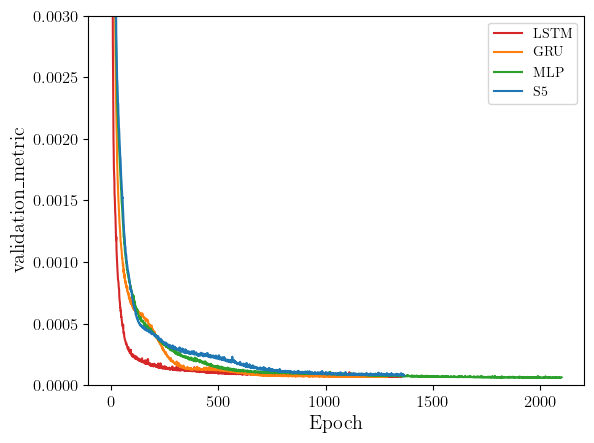

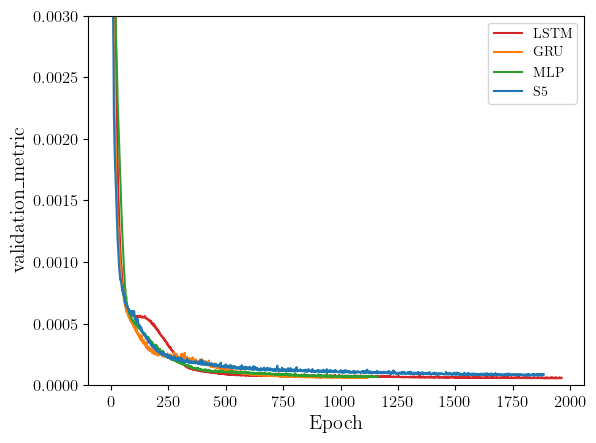

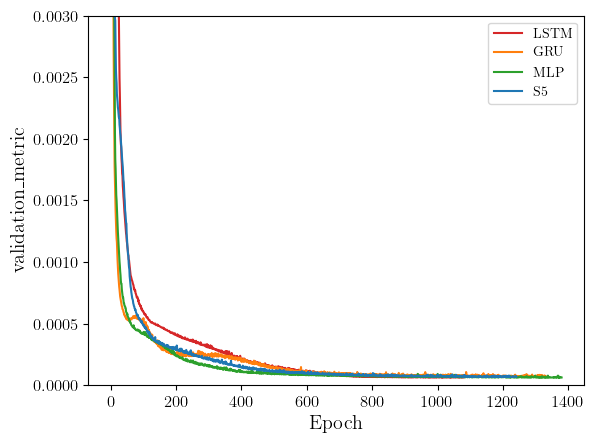

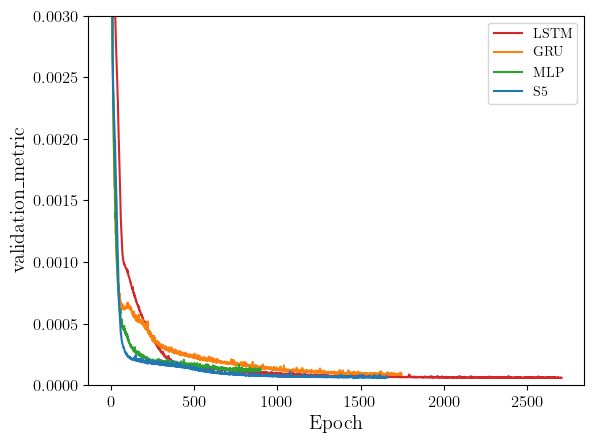

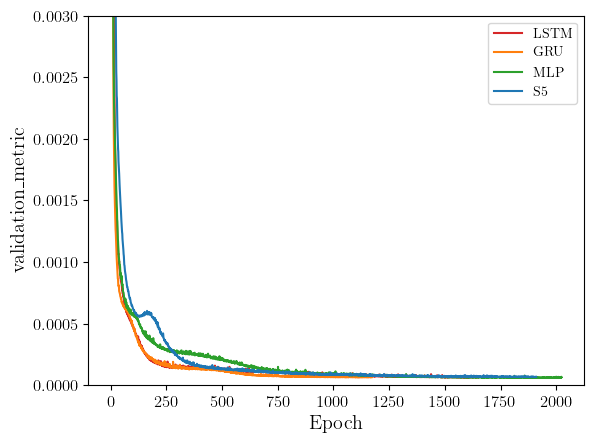

In [31]:
for cw in df['context_window'].unique():
    fig = plt.figure()
    ax = fig.add_subplot()

    for obsv in [o for o in obsv_scheme.keys() if o in df['observer'].unique()]:
        best_model = df[(df['observer'] == obsv) & (df['context_window'] == cw)].sort_values(by=['FIT'], ascending=False).iloc[0]
        plot_from_tensorboard(best_model, 'validation_metric', ax)
    
    # ax.set_yscale('log')
    ax.set_ylim(0, 3e-3)
    ax.legend()

Number of trainable parameters
---

In [32]:
# Pivot by observer class and context window (maximum n_params)
df_pivot = df.pivot_table(index=['observer', 'context_window'], values=['n_params'], aggfunc=np.max)
# One column for each context_window value
df_pivot = df_pivot.unstack(level=1)
df_pivot

/var/folders/s7/crvs3mz527n9fzs1sj_9ldv80000gn/T/ipykernel_7056/826735347.py:2: FutureWarning: The provided callable <function max at 0x106a27560> is currently using DataFrameGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'max' instead.
  df_pivot = df.pivot_table(index=['observer', 'context_window'], values=['n_params'], aggfunc=np.max)


n_params                          
context_window       10    25    50     100    150
observer                                          
FFNNObserver         298  1483  5458  20908  46358
S5Model_parscan      201   201   201    201    201
SingleLayerGRU      1048  1048  1048   1048   1048
SingleLayerLSTM     1352  1352  1352   1352   1352